In [131]:
import numpy as np
import pandas as pd
import ast 
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [171]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor

# PART 1 - Song classification and recommendation

In [133]:
spotify_dataset_subset = pd.read_csv("datasets/dataset_part_1/spotify_dataset_subset.csv")

In [134]:
print(f"Dimensions du jeu de données d'entrainement : {spotify_dataset_subset.shape[0]} lignes et {spotify_dataset_subset.shape[1]} caractéristiques.")

Dimensions du jeu de données d'entrainement : 8698 lignes et 20 caractéristiques.


In [135]:
spotify_dataset_subset.head()

,artist_name,track_name,release_date,genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Marry,Vorglühn Nachglühn,2018-10-12,"['discofox', 'partyschlager', 'schlager']",False,42,0.728,0.936,6,-2.557,1,0.1690,0.036800,0.000000,0.323,0.509,144.968,0lLA33ZtNiWUOB3oATZUbR,174631,4
1,ABBA,Chiquitita,1979,"['europop', 'swedish pop']",False,75,0.500,0.554,9,-8.108,1,0.0354,0.734000,0.000004,0.312,0.372,84.229,762B4bOcXF7I2Y8UlKTyTy,326320,4
2,Drug Squad,Dangerous Trouble,2010-08-09,['deep punk rock'],False,0,0.149,0.802,1,-9.954,1,0.0465,0.187000,0.785000,0.356,0.478,185.689,5TeP9dfDZivCzM20ucyHsy,277053,4
3,Ahmad Jamal,Poinciana,1958-05-23,"['bebop', 'cool jazz', 'jazz', 'jazz piano']",False,0,0.604,0.622,9,-9.277,1,0.0282,0.495000,0.661000,0.873,0.570,97.980,1nTaXD1Kt2qE8Oq92rjdrX,487201,4
4,Korn,Make Me Bad,1999-11-01,"['alternative metal', 'funk metal', 'nu metal'...",True,0,0.527,0.792,11,-6.693,0,0.0363,0.000122,0.037000,0.249,0.424,110.038,0w6VKmDlUJyIqRcJ6hPwLf,235493,4


## **Exercice 2**

In [136]:
df = spotify_dataset_subset.dropna()

In [137]:
def convert_to_list(x):

    if isinstance(x, str):
        return ast.literal_eval(x)
    else:
        return []

In [138]:
df['genres'] = df['genres'].apply(convert_to_list)

In [139]:
nb_unique_genre = len(np.unique(np.array([genre for sublist in df["genres"] for genre in sublist])))
print(f"Nombre de genres différents : {nb_unique_genre}")

Nombre de genres différents : 1745


In [140]:
def get_top_genres(df, n):
    
    all_genres = np.array([genre for sublist in df["genres"] for genre in sublist])

    unique_genres, counts = np.unique(all_genres, return_counts=True)
    sorted_indices = np.argsort(-counts)

    top_genres = unique_genres[sorted_indices[:n]]
    top_counts = counts[sorted_indices[:n]]


    return top_genres, top_counts

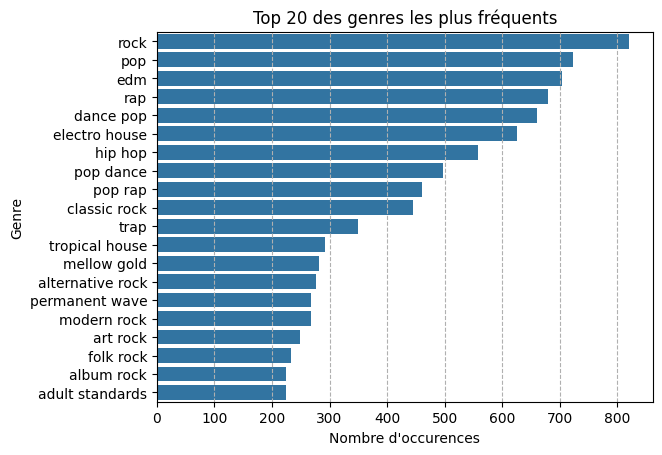

In [141]:
top_genres, top_counts = get_top_genres(df, 20)

sns.barplot(x=top_counts, y=top_genres)
plt.title("Top 20 des genres les plus fréquents")
plt.xlabel("Nombre d'occurences")
plt.ylabel("Genre")
plt.grid(axis='x', linestyle="--")
plt.show()


In [142]:
def reduce_genres(genre_list):
    macro_genres = set()
    
    for g in genre_list:
        g_str = g.lower()
        
        if any(x in g_str for x in ['rock', 'punk', 'metal', 'grunge']):
            macro_genres.add('Rock')
            
        elif any(x in g_str for x in ['rap', 'hip hop', 'trap', 'drill']):
            macro_genres.add('Rap_HipHop')
            
        elif any(x in g_str for x in ['house', 'edm', 'electro', 'techno', 'trance', 'disco', 'dance']):
            macro_genres.add('Electro_Dance')
            
        elif any(x in g_str for x in ['jazz', 'blues', 'soul', 'r&b', 'funk']):
            macro_genres.add('Jazz_Soul')
            
        elif any(x in g_str for x in ['country', 'folk']):
            macro_genres.add('Country_Folk')
            
        elif 'pop' in g_str:
            macro_genres.add('Pop')
            
        elif 'latin' in g_str or 'reggaeton' in g_str:
            macro_genres.add('Latin')
            
        elif 'classical' in g_str:
            macro_genres.add('Classical')
            
    return list(macro_genres)


In [143]:
df["macro_genres"] = df["genres"].apply(reduce_genres)

In [144]:
all_macro_genres = [genre for liste_genres in df['macro_genres'] for genre in liste_genres]

unique_macro_genres = np.unique(all_macro_genres)

print(f"Nombre de macro-genres uniques : {len(unique_macro_genres)}")
print(unique_macro_genres)

Nombre de macro-genres uniques : 8
['Classical' 'Country_Folk' 'Electro_Dance' 'Jazz_Soul' 'Latin' 'Pop'
 'Rap_HipHop' 'Rock']


In [145]:
for genre in unique_macro_genres:
    df[f"genre_{genre}"] = df["macro_genres"].apply(lambda x : 1 if genre in x else 0)


In [146]:
df["year"] = pd.to_datetime(df["release_date"], format="mixed").dt.year
df["explicit"] = df["explicit"].astype(int)

In [147]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=17)

In [148]:
to_exclude = ["id", "artist_name", "track_name", "release_date", "genres", "macro_genres", "popularity"]

X_train = train_set.drop(columns=to_exclude)
y_train = train_set["popularity"]

X_test = test_set.drop(columns=to_exclude)
y_test = test_set["popularity"]

In [149]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### **Models**

#### Random forest 

Nous avons utilisé `RandomizedSearchCV` pour affiner les hyperparamètres de la **Forêt Aléatoire**

In [162]:
random_forest = RandomForestRegressor(
    n_estimators=500, 
    min_samples_split=2, 
    min_samples_leaf=2, 
    max_features="log2", 
    max_depth=None, 
    random_state=17, 
    n_jobs=-1)
    
random_forest.fit(X_train_scaled, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [163]:
y_pred_random_forest = random_forest.predict(X_test_scaled)

In [164]:
random_forest_results = test_set[["artist_name", "track_name"]].copy()

random_forest_results["real_popularity"] = y_test
random_forest_results["predicted_popularity"] = y_pred_random_forest

random_forest_results["error"] = random_forest_results["real_popularity"] - random_forest_results["predicted_popularity"]

In [165]:
random_forest_results.head()

,artist_name,track_name,real_popularity,predicted_popularity,error
2106,deadmau5,Hyperlandia - Vocal Mix,59,31.024730,27.975270
8361,Betty Boo,Where Are You Baby?,17,38.352217,-21.352217
6274,Lil Tecca,Count Me Out,59,45.891183,13.108817
4327,Fiona Apple,Criminal,0,27.469025,-27.469025
5308,BANNERS,Ghosts,52,43.235894,8.764106


In [166]:
random_forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred_random_forest))
random_forest_mae = mean_absolute_error(y_test, y_pred_random_forest)
random_forest_r2 = r2_score(y_test, y_pred_random_forest)

print("--- Performances du modèle ---")
print(f"RMSE : {random_forest_rmse:.3f}")
print(f"MAE : {random_forest_mae:.3f}")
print(f"R² : {random_forest_r2:.3f}")

--- Performances du modèle ---
RMSE : 22.681
MAE : 19.259
R² : 0.236


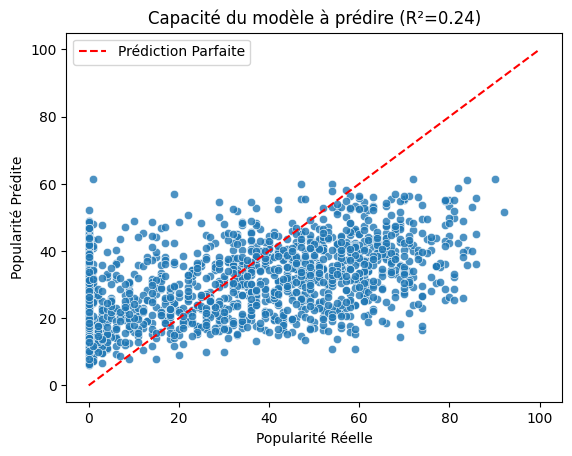

In [167]:
sns.scatterplot(x=y_test, y=y_pred_random_forest, alpha=0.8)
plt.plot([0, 100], [0, 100], "r--", label="Prédiction Parfaite")
plt.xlabel("Popularité Réelle")
plt.ylabel("Popularité Prédite")
plt.title(f"Capacité du modèle à prédire (R²={random_forest_r2:.2f})")
plt.legend()
plt.show()

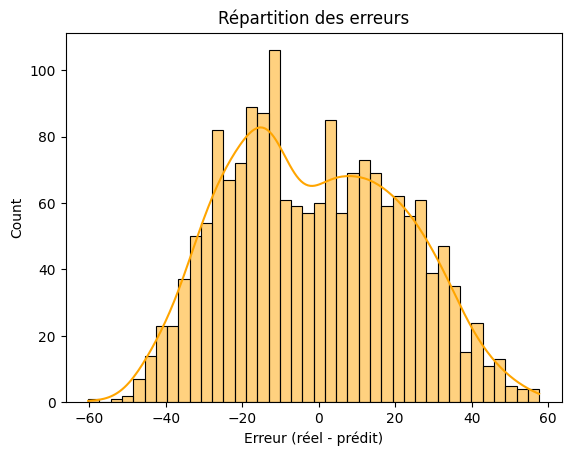

In [168]:
sns.histplot(random_forest_results["error"], bins=40, kde=True, color='orange')
plt.xlabel("Erreur (réel - prédit)")
plt.title("Répartition des erreurs")
plt.show()

#### XGBoost

In [169]:
param_grid = {
    "n_estimators" : [100, 200, 500, 1000],
    "learning_rate" : [0.01, 0.05, 0.1],
    "max_depth" : [3, 5, 7, 10, 15],
    "subsample" : [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree" : [0.7, 0.8, 0.9],
}

In [173]:
xgb = XGBRegressor(random_state=17, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=17,
    n_jobs=-1
)

In [175]:
print("Recherche des meilleurs paramètres...")
random_search.fit(X_train_scaled, y_train)
print(f"\nMeilleurs paramètres trouvés : {random_search.best_params_}")

Recherche des meilleurs paramètres...



Meilleurs paramètres trouvés : {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


In [177]:
xgb_opt = random_search.best_estimator_
y_pred_xgb_opt = xgb_opt.predict(X_test_scaled)

In [183]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb_opt)
xgb_r2 = r2_score(y_test, y_pred_xgb_opt)

print(f"RMSE XGBoost : {xgb_rmse:.3f}")
print(f"MAE XGBoost : {xgb_mae:3f}")
print(f"R² XGBoost : {xgb_r2:.3f}")

RMSE XGBoost : 24.043
MAE XGBoost : 20.311321
R² XGBoost : 0.141


In [181]:
print(f"Gain par rapport à la RF (RMSE {random_forest_rmse:.3f}) : {random_forest_rmse - xgb_rmse:.3f} points")

Gain par rapport à la RF (RMSE 22.681) : -1.362 points


### Upgrade

Dans le cadre de la popularité d'une musique, l'artiste joue un rôle important.  
Le nombre d'artistes étant trop nombreux pour faire un encodage one-hot, nous allons remplacer le nom de l'artiste par sa **popularité moyenne**. 

In [185]:
artist_means = train_set.groupby("artist_name")["popularity"].mean()
global_mean = train_set["popularity"].mean()

train_set["artist_avg_pop"] = train_set["artist_name"].map(artist_means)
test_set["artist_avg_pop"] = test_set["artist_name"].map(artist_means).fillna(global_mean)

In [190]:
X_train_up = train_set.drop(columns=to_exclude)
y_train_up = train_set["popularity"]

X_test_up = test_set.drop(columns=to_exclude)
y_test_up = test_set["popularity"]

X_train_scaled_up = scaler.fit_transform(X_train_up)
X_test_scaled_up = scaler.fit_transform(X_test_up)

In [191]:
random_forest_up = RandomForestRegressor(
    n_estimators=500, 
    random_state=17, 
    n_jobs=-1)

random_forest_up.fit(X_train_scaled_up, y_train_up)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [192]:
y_pred_random_forest_up = random_forest_up.predict(X_test_scaled_up)

In [193]:
random_forest_up_rmse = np.sqrt(mean_squared_error(y_test_up, y_pred_random_forest_up))
random_forest_up_mae = mean_absolute_error(y_test_up, y_pred_random_forest_up)
random_forest_up_r2 = r2_score(y_test_up, y_pred_random_forest_up)

print("--- Performances du modèle ---")
print(f"RMSE : {random_forest_up_rmse:.3f}")
print(f"MAE : {random_forest_up_mae:.3f}")
print(f"R² : {random_forest_up_r2:.3f}")

--- Performances du modèle ---
RMSE : 25.072
MAE : 19.316
R² : 0.066


C'est affreusement pire qu'avant